In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

from src.metadata_processing.process_sounds_metadata import generate_sounds_metadata, split_in_train_and_test
from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from src.metadata_processing.process_sounds_metadata import make_fixed_size_sounds
from src.audiodata_processing.process_waves import process_waves, butter_highpass_filter, denoise_recording
from src.audiodata_processing.extract_features_from_wave import extract_specs, extract_melspecs
from sklearn.metrics import precision_recall_curve
from collections import defaultdict
from src.util import make_image
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from src.deep_learning.splitter_analysis import *

2022-02-13 14:51:57.476156: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-13 14:51:58.412888: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-13 14:51:58.413840: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-13 14:51:58.509892: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-13 14:51:58.509926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BUBUNTU3000): /proc/driver/nvidia/version does not exist


In [2]:
path_to_models = PATH_TO_PROJECT + 'models/splitter/networks/'
path_to_datasets = PATH_TO_PROJECT + 'models/splitter/datasets/'
all_models = os.listdir(path_to_models)

models_dict = {model_name: tf.keras.models.load_model(path_to_models + model_name) for model_name in all_models}
model_names_dict = {model_name: model_name[:model_name.find('_rec-d')] for model_name in all_models}

rec_name = 'nmr_2602019 Mic 2 Tag 6 Vid Left Part 2_ptB_annotated.npy'
txt_name = 'nmr_2602019 Mic 2 Tag 6 Vid Left Part 2_ptB.txt'


2022-02-13 14:52:02.453256: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-13 14:52:02.453565: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [3]:
len(all_models)

7

### Load models data and apply them to the recording

In [8]:

model_results_dict = defaultdict(dict)
for model_name in all_models:
    
    print('Model',  model_name)
    model = models_dict[model_name]
    
    # Load data processing parameters of the model
    with open(path_to_datasets + model_name + '/params_dict.pickle', 'rb') as f:
        all_params_dict = pickle.load(f)
    
    # Load the recording and txt
    rec = np.load(PATH_TO_PROJECT + 'data/' + rec_name)
    txt = pd.read_csv(PATH_TO_PROJECT + 'data/' + txt_name, sep='\t', header=None)
    txt.columns = ['s', 'e', 'cl']
    true_rec_labels, true_sound_inds = txt_to_rec_labels(rec, txt, all_params_dict['sr'])
    # Sun splitter
    rec_predictions, pred_rec_probs = run_splitter(rec, model, all_params_dict)
    
    # Save
    model_results_dict[model_name]['model'] = model
    model_results_dict[model_name]['all_params_dict'] = all_params_dict
    model_results_dict[model_name]['rec'] = rec
    model_results_dict[model_name]['txt'] = txt
    model_results_dict[model_name]['true_rec_labels'] = true_rec_labels
    model_results_dict[model_name]['true_sound_inds'] = true_sound_inds
    model_results_dict[model_name]['rec_predictions'] = rec_predictions
    model_results_dict[model_name]['pred_rec_probs'] = pred_rec_probs
    

Model res=2048_step1024_nfft=1024_nmel=80_rec-denoise=False_highpass=3000


2022-02-06 11:18:08.377947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-06 11:18:08.398060: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz
2022-02-06 11:18:08.453445: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-06 11:18:08.954630: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-02-06 11:18:08.955182: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-02-06 11:18:10.409625: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for op

2022-02-06 11:18:11.883041: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:11.944266: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:12.005293: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:12.067344: W tensorflow/stream_executor/gpu/

2022-02-06 11:18:13.632862: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:13.693868: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:13.755574: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:13.817016: W tensorflow/stream_executor/gpu/

Model res=2048_step1024_nfft=512_nmel=80_rec-denoise=False_highpass=3000


2022-02-06 11:18:49.910291: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:49.993208: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:50.076060: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:50.158248: W tensorflow/stream_executor/gpu/

2022-02-06 11:18:52.182897: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:52.265768: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:52.349404: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:52.433816: W tensorflow/stream_executor/gpu/

2022-02-06 11:18:54.436323: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:18:54.518840: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



Model res=2048_step1024_nfft=512_nmel=40_rec-denoise=False_highpass=3000


2022-02-06 11:19:28.948968: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:19:29.043039: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:19:29.138441: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:19:29.237154: W tensorflow/stream_executor/gpu/

2022-02-06 11:19:31.590955: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:19:31.691109: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:19:31.789884: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:19:31.888935: W tensorflow/stream_executor/gpu/

2022-02-06 11:19:34.271329: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:19:34.368497: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



Model res=2048_step512_nfft=512_nmel=80_rec-denoise=False_highpass=3000
Model res=2048_step1024_nfft=1024_nmel=40_rec-denoise=False_highpass=3000


2022-02-06 11:21:21.426241: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:21:21.555480: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:21:21.684761: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:21:21.814786: W tensorflow/stream_executor/gpu/

2022-02-06 11:21:25.077155: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:21:25.205255: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:21:25.342335: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:21:25.471797: W tensorflow/stream_executor/gpu/

Model res=1024_step512_nfft=512_nmel=80_rec-denoise=False_highpass=3000


2022-02-06 11:22:32.026136: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:22:32.168413: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:22:32.316180: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:22:32.457643: W tensorflow/stream_executor/gpu/

2022-02-06 11:22:36.004380: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:22:36.142168: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:22:36.282080: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:22:36.416941: W tensorflow/stream_executor/gpu/

Model res=1024_step256_nfft=512_nmel=80_rec-denoise=False_highpass=3000


2022-02-06 11:24:40.107286: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:24:40.280905: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:24:40.456096: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:24:40.631850: W tensorflow/stream_executor/gpu/

2022-02-06 11:24:45.068937: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:24:45.247684: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:24:45.426112: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-02-06 11:24:45.600689: W tensorflow/stream_executor/gpu/

### Study sample-based precision and recall

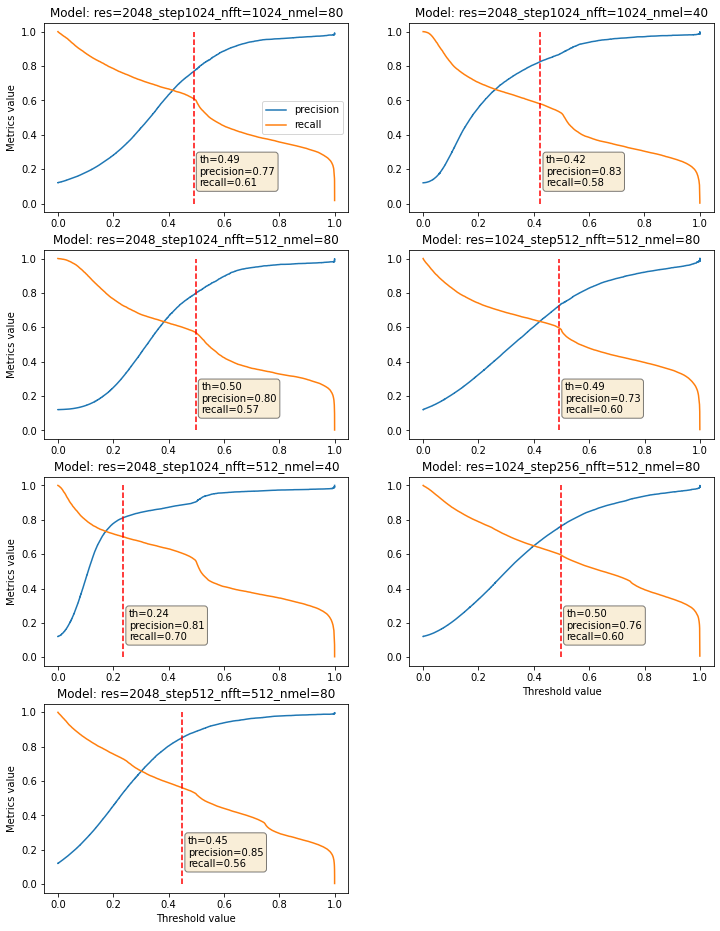

In [11]:
plot_x = 2
plot_y = 4
weight_recall = 1.4

fig, axs = plt.subplots(plot_y, plot_x, figsize=(plot_x *6, plot_y * 4), sharex=False, sharey=False)
for xi in range(plot_x):
    for yi in range(plot_y):
        model_ind = xi * plot_y + yi
        if model_ind >= len(all_models):
            break
            
        model_name = all_models[model_ind]
        model = model_results_dict[model_name]['model']        
        true_rec_labels = model_results_dict[model_name]['true_rec_labels']
        pred_rec_probs = model_results_dict[model_name]['pred_rec_probs']
        
        try:
            precision = model_results_dict[model_name]['precision']
            recall = model_results_dict[model_name]['recall']
            thresholds = model_results_dict[model_name]['thresholds']
        except:
            precision, recall, thresholds = precision_recall_curve(true_rec_labels, pred_rec_probs)
            model_results_dict[model_name]['precision'] = precision
            model_results_dict[model_name]['recall'] = recall
            model_results_dict[model_name]['thresholds'] = thresholds
                
        best_th_ind = np.argmax(precision + weight_recall * recall)
        best_th = thresholds[best_th_ind]
        text = 'th=%.2f\nprecision=%.2f\nrecall=%.2f' % (best_th, precision[best_th_ind], recall[best_th_ind])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        model_results_dict[model_name]['best_th'] = best_th
        
        
        axs[yi, xi].plot(thresholds, precision[:-1], label='precision')
        axs[yi, xi].plot(thresholds, recall[:-1], label='recall')
        axs[yi, xi].vlines(best_th, 0, 1, colors='red', linestyles='dashed')
        axs[yi, xi].text(best_th + .02, 0.1, text, bbox=props)
        

        axs[yi, xi].set_title('Model: %s' % model_names_dict[model_name])
        if xi == 0:
            _  = axs[yi, xi].set_ylabel('Metrics value')
        if yi == 3 or (yi == 2 and xi == 1):
            _  = axs[yi, xi].set_xlabel('Threshold value')
_ = axs[0, 0].legend()
fig.delaxes(axs[-1, -1])

### Study what happens for these best thresholds

In [204]:
per_model_results = {}
for model_name in all_models:
    print(model_name)
    sr = all_params_dict['sr']
    model = model_results_dict[model_name]['model']
    all_params_dict = model_results_dict[model_name]['all_params_dict']
    rec = model_results_dict[model_name]['rec']
    txt = model_results_dict[model_name]['txt']
    true_rec_labels = model_results_dict[model_name]['true_rec_labels']
    true_sound_inds = model_results_dict[model_name]['true_sound_inds']
    rec_predictions = model_results_dict[model_name]['rec_predictions']
    pred_rec_probs = model_results_dict[model_name]['pred_rec_probs']


    th = model_results_dict[model_name]['best_th']
    pred_rec_labels, pred_sound_inds = map_prediction_to_sounds(pred_rec_probs, th, min_length=512)
    
    true_pixel_to_sound_index = np.zeros(len(rec), dtype='int')
    for ind, (s, e) in enumerate(txt[['s', 'e']].values):
        s_int, e_int = int(s * sr), int(e * sr)
        true_pixel_to_sound_index[s_int: e_int] = ind + 1

    true_sound_ind_to_pixels = {}
    for ind, (s, e) in enumerate(txt[['s', 'e']].values):
        s_int, e_int = int(s * sr), int(e * sr)
        true_sound_ind_to_pixels[ind + 1] = (s_int, e_int)

    pred_pixel_to_sound_index = np.zeros(len(rec), dtype='int')
    for ind, (s_int, e_int) in enumerate(pred_sound_inds):
        pred_pixel_to_sound_index[s_int: e_int] = ind + 1

    pred_sound_ind_to_pixels = {}
    for ind, (s_int, e_int) in enumerate(pred_sound_inds):
        pred_sound_ind_to_pixels[ind + 1] = (s_int, e_int)
    
    precision_results, precision_results_count = study_precision(pred_sound_inds, true_pixel_to_sound_index, 
                                                             true_sound_ind_to_pixels,  
                                                             full_cover_th=0.85, partial_cover_th=0.5)
    
    recall_results, recall_results_count = study_recall(true_sound_inds, pred_rec_labels, 
                                                        pred_pixel_to_sound_index, 
                                                        detected_th=0.8, partly_detected_th=0.5,
                                                        partial_cover_th=.3)
    
    print('True number of sounds:', len(txt))
    print('Predicted number of sounds:', len(pred_sound_inds))
    
    print('Precision results:')
    for key, val in precision_results_count.items():
        print('  ', key, '--',  val)

    print('Recall results:')
    for key, val in recall_results_count.items():
        print('  ', key, '--', val)
        
    per_model_results[model_name] = {'precision': precision_results_count, 'recall': recall_results_count}

res=2048_step1024_nfft=1024_nmel=80_rec-denoise=False_highpass=3000
True number of sounds: 2752
Predicted number of sounds: 3200
Precision results:
   0full_1partial -- 870
   0full_0partial -- 1594
   1full_0partial -- 529
   1full_1partial -- 76
   2full_0partial -- 83
   1full_2partial -- 3
   3full_1partial -- 1
   0full_2partial -- 26
   2full_1partial -- 10
   3full_0partial -- 6
   0full_3partial -- 2
Recall results:
   partly_in_1 -- 795
   fully_in_1 -- 1072
   missed -- 879
   partly_in_2 -- 4
   partly_in_0 -- 2
res=2048_step1024_nfft=512_nmel=80_rec-denoise=False_highpass=3000
True number of sounds: 2752
Predicted number of sounds: 2729
Precision results:
   0full_1partial -- 764
   0full_0partial -- 1273
   1full_0partial -- 494
   1full_1partial -- 81
   2full_0partial -- 76
   2full_2partial -- 1
   0full_3partial -- 3
   2full_1partial -- 6
   0full_2partial -- 19
   3full_0partial -- 6
   1full_2partial -- 6
Recall results:
   missed -- 1027
   fully_in_1 -- 1007
   pa

In [206]:
set(precision_results)

{'0full_0partial',
 '0full_1partial',
 '0full_2partial',
 '0full_3partial',
 '1full_0partial',
 '1full_1partial',
 '1full_2partial',
 '2full_0partial',
 '2full_1partial',
 '3full_0partial'}

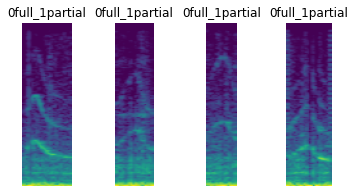

In [216]:
#vals =  ['1full_1partial', '2full_1partial', '3full_0partial', '2full_0partial']
vals =  ['0full_1partial', ]
inds = np.where([pd.Series(precision_results).isin(vals)])[1]
np.random.shuffle(inds)


plt.figure(figsize=(6, 3))
for x in range(4):
    ind = inds[x]
    plt.subplot(1, 4, x +1)
    pred_s_int, pred_e_int = pred_sound_inds[ind]
    sound = rec[pred_s_int: pred_e_int]
    plt.imshow(make_image(sound))
    _ = plt.title(precision_results[ind])
    plt.axis('off')

In [201]:
set(recall_results)

{'fully_in_1',
 'fully_in_2',
 'missed',
 'partly_in_0',
 'partly_in_1',
 'partly_in_2'}

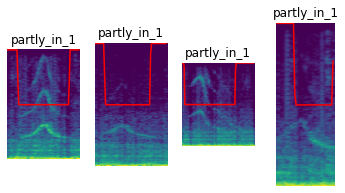

In [208]:
#vals =  ['1full_1partial', '2full_1partial', '3full_0partial', '2full_0partial']
vals = ['partly_in_1']
#vals =  ['fully_in_2', 'partly_in_2']
#vals = ['missed']
inds = np.where([pd.Series(recall_results).isin(vals)])[1]
np.random.shuffle(inds)


plt.figure(figsize=(6, 3))
for x in range(4):
    ind = inds[x]
    plt.subplot(1, 4, x +1)
    true_s_int, true_e_int = true_sound_inds[ind]
    #prediction = 
    sound = rec[true_s_int: true_e_int]
    img = make_image(sound)
    factor = (sound.shape[0]/ img.shape[1])
    prediction = pred_rec_labels[true_s_int : true_e_int]
    img_labels  = []
    for i in np.arange(0, len(sound) - factor, factor):
        pixel_label = np.mean(prediction[int(i): int(i + factor)])
        img_labels.append(64 * pixel_label)
    plt.plot(img_labels, c='red')
    
    plt.imshow(img)
    _ = plt.title(recall_results[ind])
    plt.axis('off')

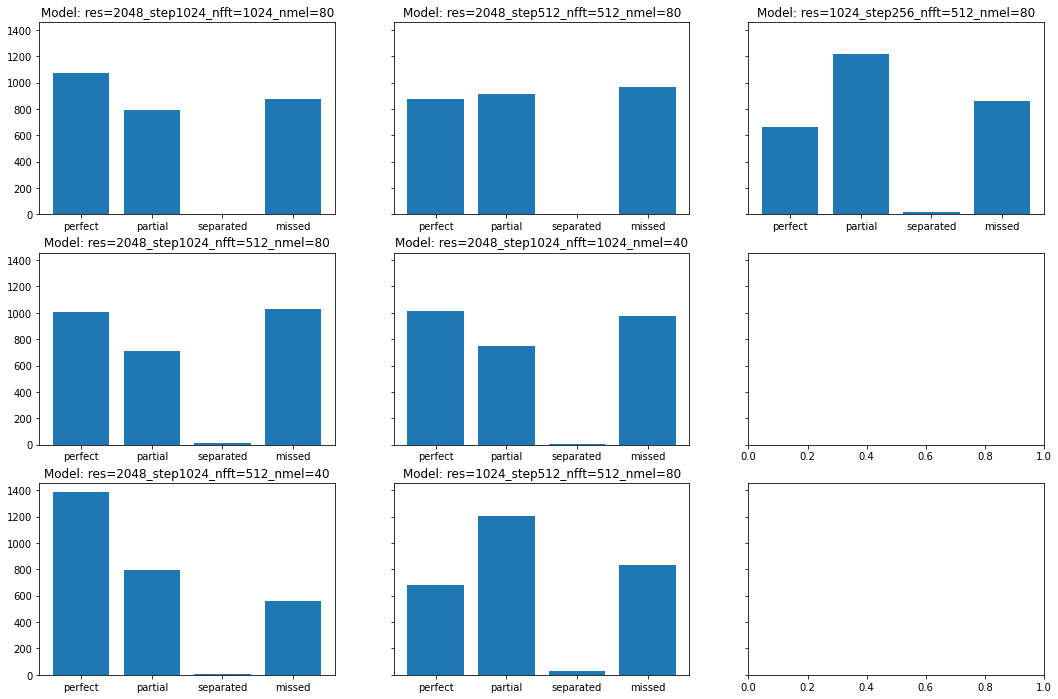

In [218]:

result_group_dict = {'fully_in_1': 'perfect', 'partly_in_1': 'partial', 'missed': 'missed'}
plot_x = 3
plot_y = 3
fig, axs = plt.subplots(plot_y, plot_x, figsize=(plot_x *6, plot_y * 4), sharex=False, sharey=True)

for xi in range(plot_x):
    for yi in range(plot_y):
        model_ind = xi * plot_y + yi
        if model_ind >= len(all_models):
            break
        model_name = all_models[model_ind]
        recall_results_count = per_model_results[model_name]['recall']
        recall_results_grouped = {}
        for key, val in recall_results_count.items():
            group_key = result_group_dict[key] if key in result_group_dict else 'separated'
            if group_key in recall_results_grouped:
                recall_results_grouped[group_key] += val
            else:
                recall_results_grouped[group_key] = val
        x = sorted(recall_results_grouped.keys())
        x = ['perfect', 'partial', 'separated', 'missed']
        y = [recall_results_grouped[k] if k in recall_results_grouped else 0 for k in x]
        _ =  axs[yi, xi].bar(x, y)
        axs[yi, xi].set_title('Model: %s' % model_names_dict[model_name])

In [219]:
precision_results_count

defaultdict(<function src.deep_learning.splitter_analysis.study_precision.<locals>.<lambda>()>,
            {'1full_0partial': 281,
             '0full_0partial': 2382,
             '0full_1partial': 1180,
             '0full_2partial': 38,
             '2full_0partial': 26,
             '1full_1partial': 78,
             '2full_1partial': 4,
             '0full_3partial': 2,
             '1full_2partial': 4,
             '3full_0partial': 1})

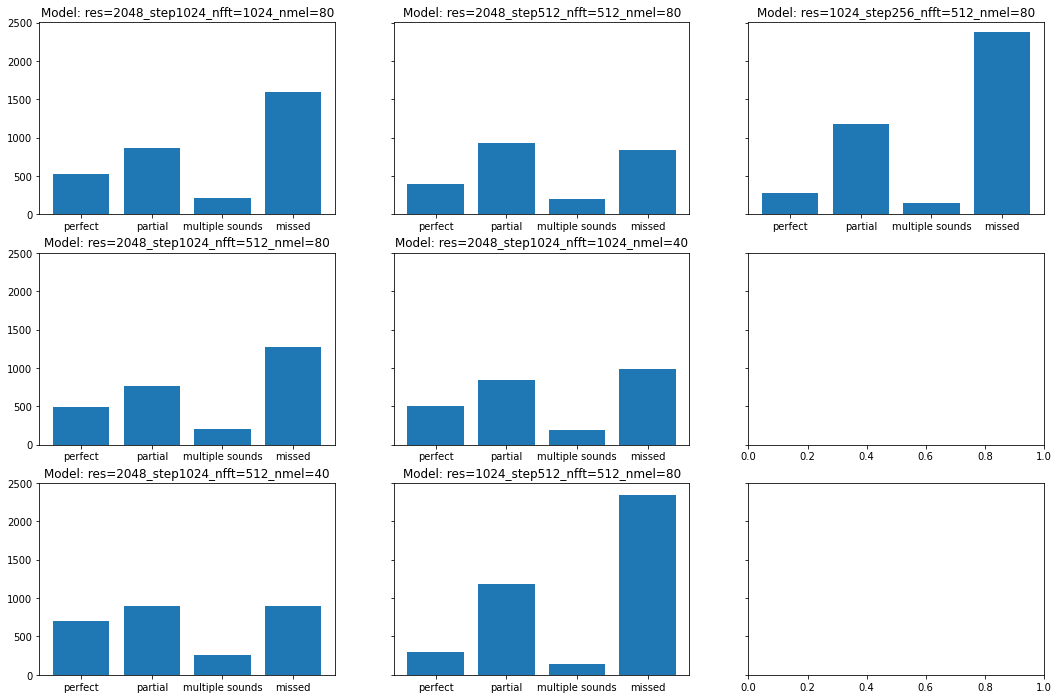

In [220]:

result_group_dict = {'1full_0partial': 'perfect', '0full_1partial': 'partial', '0full_0partial': 'missed'}
plot_x = 3
plot_y = 3
fig, axs = plt.subplots(plot_y, plot_x, figsize=(plot_x *6, plot_y * 4), sharex=False, sharey=True)

for xi in range(plot_x):
    for yi in range(plot_y):
        model_ind = xi * plot_y + yi
        if model_ind >= len(all_models):
            break
        model_name = all_models[model_ind]
        precision_results_count = per_model_results[model_name]['precision']
        precision_results_grouped = {}
        for key, val in precision_results_count.items():
            group_key = result_group_dict[key] if key in result_group_dict else 'multiple sounds'
            if group_key in precision_results_grouped:
                precision_results_grouped[group_key] += val
            else:
                precision_results_grouped[group_key] = val
        x = ['perfect', 'partial', 'multiple sounds', 'missed']
        y = [precision_results_grouped[k] if k in precision_results_grouped else 0 for k in x]
        _ =  axs[yi, xi].bar(x, y)
        axs[yi, xi].set_title('Model: %s' % model_names_dict[model_name])

In [51]:
 model_results_dict[model_name].keys()

dict_keys(['model', 'all_params_dict', 'rec', 'txt', 'true_rec_labels', 'true_sound_inds', 'rec_predictions', 'pred_rec_probs', 'precision', 'recall', 'thresholds', 'best_th'])

In [34]:
recall_results_grouped

{'missed': 859, 'partial': 1215, 'perfect': 660, 'multisplit': 18}

<BarContainer object of 4 artists>

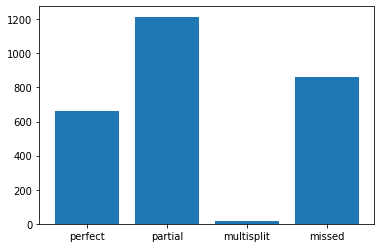

In [43]:
plt.bar(x, y)

In [39]:
y

[859, 0, 0, 0]

In [278]:

img = make_image(rec)

In [279]:
img.shape

(128, 1286419)

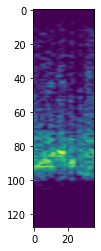

In [280]:
# show random splits
px_to_smp = (len(rec) / img.shape[1])
sec_to_px = sr / (len(rec) / img.shape[1])

i = np.random.randint(0, len(pred_sound_inds))
s_smp, e_smp = pred_sound_inds[i]
s_px, e_px = int(sec_to_px * s_smp / sr), int(sec_to_px * e_smp / sr)
plt.imshow(img[:, s_px : e_px])

In [281]:
img_labels = []
for ind in np.arange(0, len(rec) - px_to_smp, px_to_smp):
    pixel_label = np.mean(rec_labels[int(ind): int(ind + px_to_smp)])
    img_labels.append(pixel_label)
img_labels = np.array(img_labels)

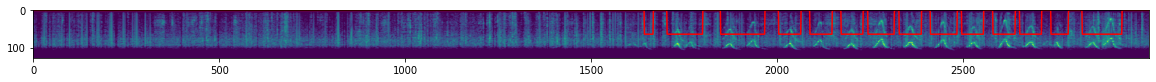

In [315]:
# show big spec with splits
plt.figure(figsize = (20, 10))

start = np.random.randint(0, img.shape[1] - 4000)
end = start + 3000

plt.imshow(img[:, start : end])
plt.plot(64 * (img_labels[start : end] >= th), c = 'red')